In [1]:
import pandas as pd
import torch
#import torch_geometric 
#import torch_geometric_temporal
import numpy as np

import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib.pyplot as plt

import networkx as nx
from scipy.spatial.distance import euclidean

import torch
from torch_geometric.data import Data

from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.interpolate import CubicSpline

In [150]:
FLOWDATA_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\FlowData_for_SubsetGraph_12_with_7SensoredPipes.csv"
SUBSETGRAPH_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\SubsetGraph_12_with_7SensoredPipes.csv"

df_flowdata = pd.read_csv(FLOWDATA_PATH, index_col=0)
df_flowdata.index = pd.to_datetime(df_flowdata.index, format='%d/%m/%Y %H:%M')

pd.set_option('display.max_rows', 500)

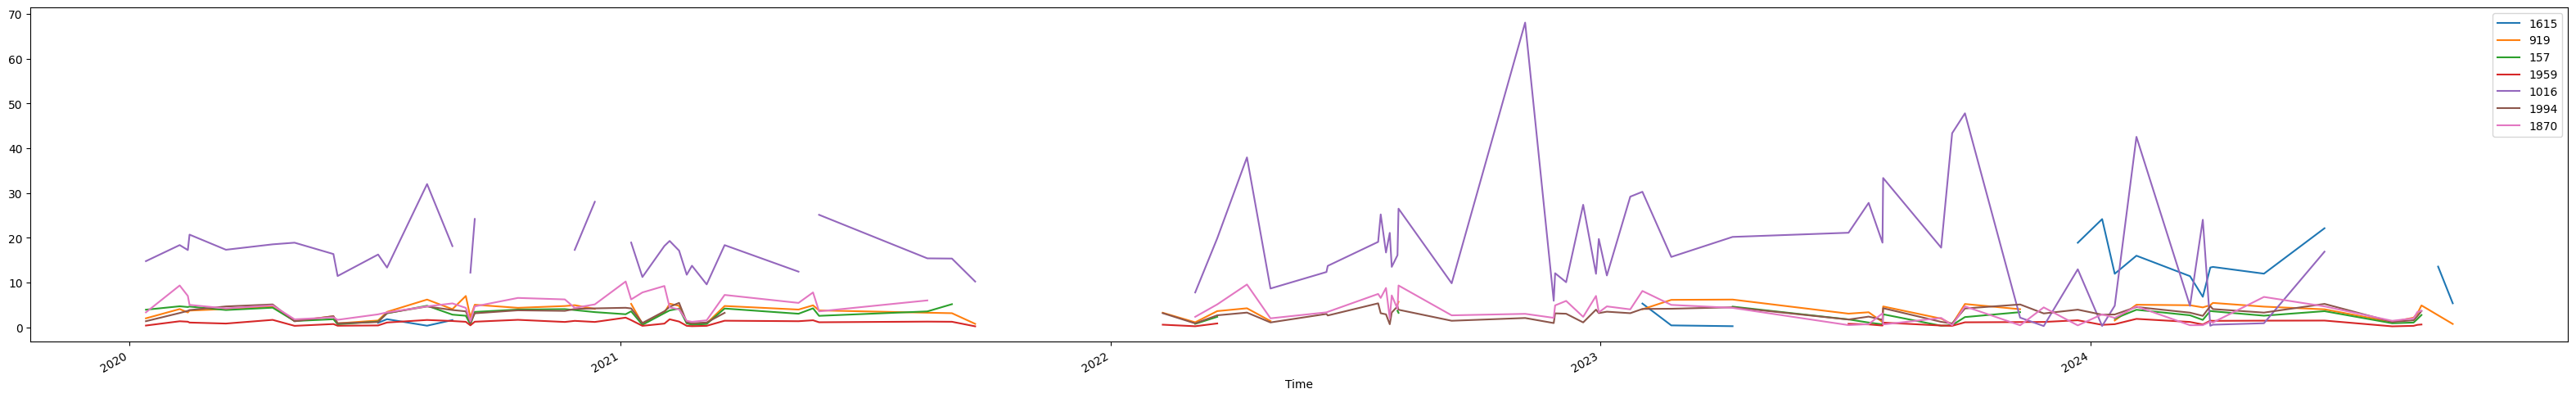

In [106]:
df_sample = df_flowdata.sample(n=96).sort_index()

df_sample.plot(
    figsize=(40, 6),
    sharex=True
)
plt.show()

data cleaning

In [151]:

def find_long_nan_sections(df, max_gap):

    # create a mask for all of the rows with missing values
    missing_vals = df.isna()

    # identify all blocks of missing values
    ###############################################################
    
    prev_row_missing_vals = missing_vals.shift()

    # find the rows where the value of a sensor changes from nan > value, or value > nan
    transition_rows = missing_vals != prev_row_missing_vals

    # assign an id number to each block of vals
    block_ids = transition_rows.cumsum()
    ####################################################################

    # find the length of each gap
    gap_lengths = missing_vals.groupby(block_ids).transform('sum')

    # identify all gaps which are longer than 4 hours
    long_gaps = missing_vals & (gap_lengths > max_gap)

    return long_gaps
    
def find_outlier_values(series):
    rolling_med = series.rolling(window=24, center=True).median()
    diff = (series - rolling_med).abs()
    threshold = 5 * diff.rolling(window=24, center=True).median()
    outlier_mask = diff > threshold
    return outlier_mask


max_gap = 16

df_flowdata = df_flowdata.drop('1615', axis=1)

rows_to_remove = pd.Series(False, index=df_flowdata.index) 
for col in df_flowdata.columns:
    rows_to_remove |= find_long_nan_sections(df_flowdata[col], max_gap)
    #rows_to_remove |= find_outlier_values(df_flowdata[col])


df_flowdata = df_flowdata[rows_to_remove == False]

df_flowdata




,919,157,1959,1016,1994,1870
Time,,,,,,
2020-01-01 00:00:00,2.811111,5.344444,0.888889,21.999999,1.888889,3.555556
2020-01-01 00:15:00,2.166667,5.244444,0.766667,22.544444,1.822222,3.333333
2020-01-01 00:30:00,2.655556,5.433334,0.855556,22.844444,1.966667,3.666667
2020-01-01 00:45:00,2.633333,5.355556,0.800000,22.111110,2.300000,3.222222
2020-01-01 01:00:00,2.533333,5.144445,0.866667,21.244444,1.944445,3.222222
...,...,...,...,...,...,...
2024-09-29 21:45:00,3.211111,2.088889,0.655556,8.477776,2.038889,2.666667
2024-09-29 22:00:00,2.988889,1.577778,0.622222,9.311110,1.890000,2.333333
2024-09-29 22:15:00,3.433333,1.766667,0.733333,9.866665,1.825556,2.000000


missing value imputation

In [159]:
gap_mask = df_flowdata.index.to_series().diff() > pd.Timedelta(minutes=15)


df_flowdata[gap_mask]
#df_flowdata[gap_mask].shape

,919,157,1959,1016,1994,1870
Time,,,,,,
2020-02-29 20:30:00,2.866667,1.522222,0.888889,14.688888,3.300000,3.000000
2020-04-29 23:00:00,1.555556,1.188889,0.344444,18.888889,1.500000,2.000000
2020-04-30 23:00:00,1.544444,1.066667,0.288889,20.000000,1.711111,2.555556
2020-05-01 23:00:00,1.855556,1.377778,0.344444,18.888889,1.822222,1.777778
2020-05-02 23:00:00,1.855556,1.266667,0.400000,17.777778,2.066667,1.666667
2020-05-03 23:00:00,1.366667,1.277778,0.500000,18.888889,1.433333,2.111111
2020-05-04 23:00:00,1.566667,1.100000,0.344444,21.111111,1.733333,2.777778
2020-05-06 23:00:00,2.300000,1.311111,0.477778,21.111111,1.600000,3.333333
2020-05-07 23:00:00,1.844445,1.166667,0.511111,17.777778,1.866667,1.666667


stratified random sampling

In [35]:

strata_dict = {
    'time_of_day': {
        'feature_origin': df_flowdata.index.hour,
        'bins': [0, 6, 12, 14, 18, 22, 24],  
        'labels': ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']
    },

    'part_of_week': {
        'feature_origin': df_flowdata.index.dayofweek,
        'bins': [0, 5, 7], 
        'labels': ['weekday', 'weekend']
    },

    'season': {
        'feature_origin': df_flowdata.index.month,
        'bins': [0, 3, 6, 9, 12, 13], 
        'labels': ['winter', 'spring', 'summer', 'autumn', 'winter']
    }
}


for strata_name, strata in strata_dict.items():
    df_flowdata[strata_name] = pd.cut(
        strata['feature_origin'],
        bins=strata['bins'],
        labels=strata['labels'],
        right=False,  
        include_lowest=True,
        ordered=False
    )

In [ ]:
gap_mask = df_flowdata.index.to_series().diff() > pd.Timedelta(minutes=15)

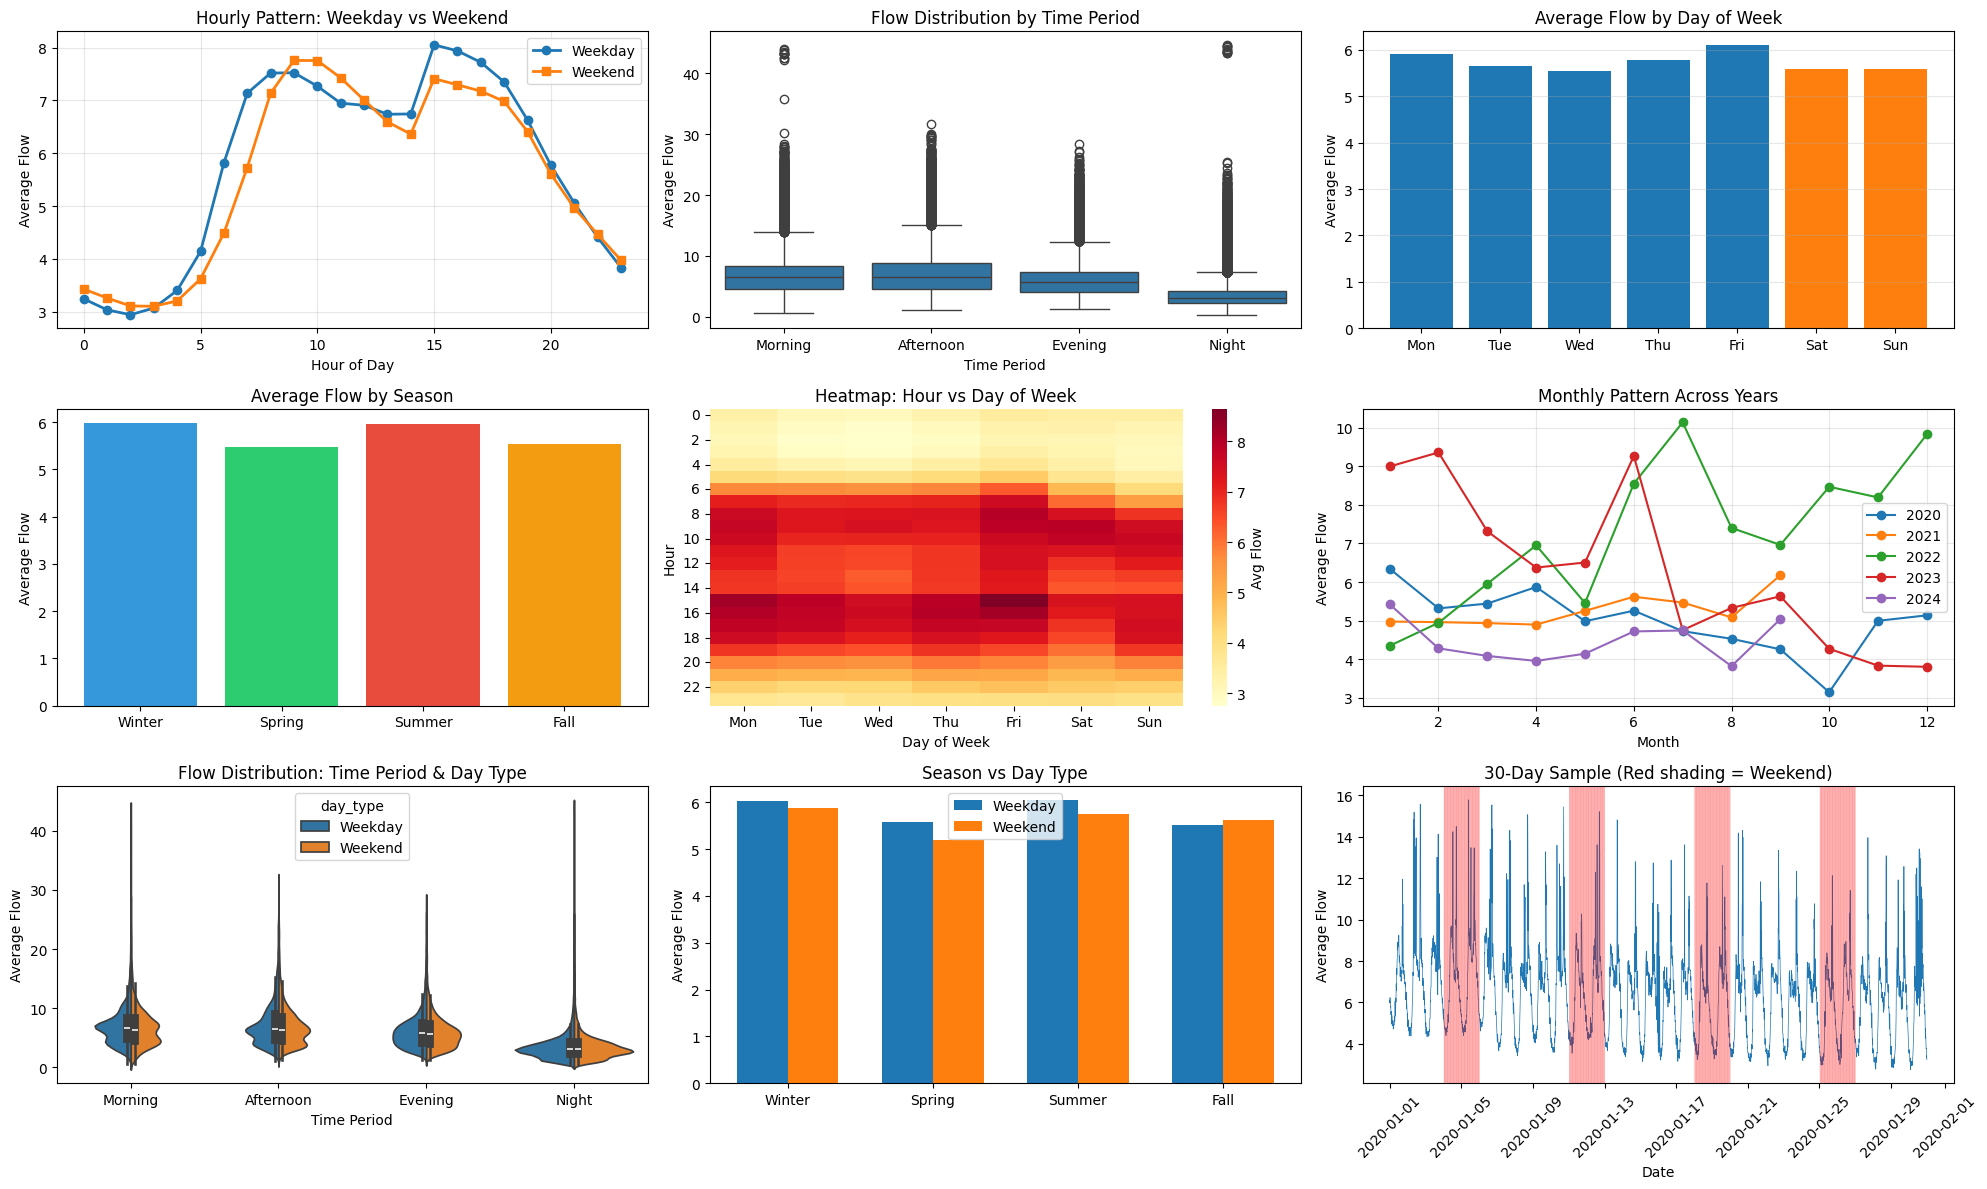


=== Summary Statistics by Potential Stratification Classes ===

1. Weekday vs Weekend:
             count      mean       std       min       25%       50%  \
day_type                                                               
Weekday   112512.0  5.800678  3.558571  0.327111  3.322222  5.106826   
Weekend    45025.0  5.595095  3.326829  0.426111  3.235185  4.898000   

               75%        max  
day_type                       
Weekday   7.348750  44.675926  
Weekend   7.235185  28.601481  

2. Time Period:
               count      mean       std       min       25%       50%  \
time_period                                                              
Afternoon    39384.0  7.242931  3.724421  1.114444  4.614564  6.474074   
Evening      26256.0  6.141799  2.977277  1.256722  4.082222  5.672222   
Morning      39384.0  6.944239  3.378525  0.596296  4.586468  6.590458   
Night        52513.0  3.514529  2.331696  0.327111  2.177778  3.081481   

                  75%        max 

In [7]:


# Assuming df_flowdata is already loaded with datetime index

# Add temporal features for analysis
df_flowdata['hour'] = df_flowdata.index.hour
df_flowdata['day_of_week'] = df_flowdata.index.dayofweek  # 0=Monday, 6=Sunday
df_flowdata['month'] = df_flowdata.index.month
df_flowdata['is_weekend'] = df_flowdata['day_of_week'].isin([5, 6]).astype(int)
df_flowdata['season'] = (df_flowdata['month'] % 12 + 3) // 3  # 1=Winter, 2=Spring, 3=Summer, 4=Fall

# Define time of day periods
def get_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df_flowdata['time_period'] = df_flowdata['hour'].apply(get_time_period)

# Get sensor column names (excluding the temporal features we just added)
sensor_cols = [col for col in df_flowdata.columns if col not in 
               ['hour', 'day_of_week', 'month', 'is_weekend', 'season', 'time_period']]

# Calculate average flow across all sensors for summary visualizations
df_flowdata['avg_flow'] = df_flowdata[sensor_cols].mean(axis=1)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Hourly patterns: Weekday vs Weekend
ax1 = plt.subplot(3, 3, 1)
hourly_weekday = df_flowdata[df_flowdata['is_weekend']==0].groupby('hour')['avg_flow'].mean()
hourly_weekend = df_flowdata[df_flowdata['is_weekend']==1].groupby('hour')['avg_flow'].mean()
ax1.plot(hourly_weekday.index, hourly_weekday.values, label='Weekday', marker='o', linewidth=2)
ax1.plot(hourly_weekend.index, hourly_weekend.values, label='Weekend', marker='s', linewidth=2)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Flow')
ax1.set_title('Hourly Pattern: Weekday vs Weekend')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot by time period
ax2 = plt.subplot(3, 3, 2)
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
sns.boxplot(data=df_flowdata, x='time_period', y='avg_flow', order=time_order, ax=ax2)
ax2.set_title('Flow Distribution by Time Period')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Average Flow')

# 3. Day of week pattern
ax3 = plt.subplot(3, 3, 3)
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_pattern = df_flowdata.groupby('day_of_week')['avg_flow'].mean()
ax3.bar(range(7), daily_pattern.values, color=['#1f77b4']*5 + ['#ff7f0e']*2)
ax3.set_xticks(range(7))
ax3.set_xticklabels(day_names)
ax3.set_title('Average Flow by Day of Week')
ax3.set_ylabel('Average Flow')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Seasonal patterns
ax4 = plt.subplot(3, 3, 4)
season_names = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
seasonal_pattern = df_flowdata.groupby('season')['avg_flow'].mean()
ax4.bar(seasonal_pattern.index, seasonal_pattern.values, 
        color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
ax4.set_xticks([1, 2, 3, 4])
ax4.set_xticklabels([season_names[i] for i in [1, 2, 3, 4]])
ax4.set_title('Average Flow by Season')
ax4.set_ylabel('Average Flow')

# 5. Heatmap: Hour vs Day of Week
ax5 = plt.subplot(3, 3, 5)
pivot_data = df_flowdata.pivot_table(values='avg_flow', 
                                     index='hour', 
                                     columns='day_of_week', 
                                     aggfunc='mean')
sns.heatmap(pivot_data, cmap='YlOrRd', ax=ax5, cbar_kws={'label': 'Avg Flow'})
ax5.set_yticklabels(ax5.get_yticklabels(), rotation=0)
ax5.set_xticklabels(day_names)
ax5.set_title('Heatmap: Hour vs Day of Week')
ax5.set_xlabel('Day of Week')
ax5.set_ylabel('Hour')

# 6. Monthly pattern over years
ax6 = plt.subplot(3, 3, 6)
df_flowdata['year'] = df_flowdata.index.year
monthly_yearly = df_flowdata.groupby(['year', 'month'])['avg_flow'].mean().reset_index()
for year in df_flowdata['year'].unique():
    year_data = monthly_yearly[monthly_yearly['year'] == year]
    ax6.plot(year_data['month'], year_data['avg_flow'], marker='o', label=str(year))
ax6.set_xlabel('Month')
ax6.set_ylabel('Average Flow')
ax6.set_title('Monthly Pattern Across Years')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Violin plot: Weekday vs Weekend by Time Period
ax7 = plt.subplot(3, 3, 7)
df_flowdata['day_type'] = df_flowdata['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})
sns.violinplot(data=df_flowdata, x='time_period', y='avg_flow', 
               hue='day_type', split=True, order=time_order, ax=ax7)
ax7.set_title('Flow Distribution: Time Period & Day Type')
ax7.set_xlabel('Time Period')
ax7.set_ylabel('Average Flow')

# 8. Season vs Weekend/Weekday
ax8 = plt.subplot(3, 3, 8)
season_day_pattern = df_flowdata.groupby(['season', 'day_type'])['avg_flow'].mean().reset_index()
weekday_data = season_day_pattern[season_day_pattern['day_type'] == 'Weekday']
weekend_data = season_day_pattern[season_day_pattern['day_type'] == 'Weekend']
x = np.arange(len(season_names))
width = 0.35
ax8.bar(x - width/2, weekday_data['avg_flow'], width, label='Weekday')
ax8.bar(x + width/2, weekend_data['avg_flow'], width, label='Weekend')
ax8.set_xticks(x)
ax8.set_xticklabels([season_names[i] for i in sorted(season_names.keys())])
ax8.set_title('Season vs Day Type')
ax8.set_ylabel('Average Flow')
ax8.legend()

# 9. Time series overview with stratification markers
ax9 = plt.subplot(3, 3, 9)
# Sample a subset for visualization (e.g., one month)
sample_start = df_flowdata.index[0]
sample_end = sample_start + pd.Timedelta(days=30)
sample_data = df_flowdata[(df_flowdata.index >= sample_start) & (df_flowdata.index <= sample_end)]
ax9.plot(sample_data.index, sample_data['avg_flow'], linewidth=0.5)
# Color weekends
for idx in sample_data[sample_data['is_weekend']==1].index:
    ax9.axvline(idx, color='red', alpha=0.1, linewidth=0.5)
ax9.set_title('30-Day Sample (Red shading = Weekend)')
ax9.set_xlabel('Date')
ax9.set_ylabel('Average Flow')
ax9.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('flow_pattern_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis: Identify optimal number of clusters
print("\n=== Summary Statistics by Potential Stratification Classes ===\n")

print("1. Weekday vs Weekend:")
print(df_flowdata.groupby('day_type')['avg_flow'].describe())

print("\n2. Time Period:")
print(df_flowdata.groupby('time_period')['avg_flow'].describe())

print("\n3. Season:")
print(df_flowdata.groupby('season')['avg_flow'].agg(['mean', 'std', 'min', 'max']))

print("\n4. Combined: Day Type × Time Period:")
print(df_flowdata.groupby(['day_type', 'time_period'])['avg_flow'].mean())

# Clean up temporary columns if desired
# df_flowdata = df_flowdata[sensor_cols]